In [1]:
import matplotlib.pyplot as plt
plt.style.use(['seaborn-notebook', 'seaborn-white', 'seaborn-ticks'])

import numpy as np

import mlgrad.model as model
import mlgrad.loss as loss
import mlgrad.func as func
import mlgrad.regular as regular
import mlgrad.avragg as avragg

from mlgrad import erm_fg, erm_irgd, fg, weights, averager_it, erisk, sg, erm_sg

#import sklearn.linear_model as sklm
#import sklearn.datasets as datasets

#plt.style.available

In [2]:
def get_y(lm_line, x):
    return (-lm_line.param[0]-lm_line.param[1]*x)/lm_line.param[2]

In [30]:
def draw_line(lm_line, X, Y, **kw):
    X1, X2 = X[:,0], X[:,1]
    x1_min, x1_max = X1.min(), X1.max()
    x2_min, x2_max = X2.min(), X2.max()
    y1_min = get_y(lm_line, x1_min)
    y1_max = get_y(lm_line, x1_max)

    plt.plot([x1_min, x1_max], [y1_min, y1_max], color='k', linewidth=1.6, **kw)
    
def draw_map(lm_line, X, Y, title):
    plt.figure(figsize=(4.,3.))
    Yp = lm_line.evaluate_all(X)
    plt.title(title)
#     plt.minorticks_on()
    X1, X2 = X[:,0], X[:,1]
    plt.scatter(X1, X2, c=Y, s=16, cmap=plt.cm.gray, edgecolors='k', linewidth=0.5)

    x1_min, x1_max = X1.min(), X1.max()
    x2_min, x2_max = X2.min(), X2.max()
    y1_min = get_y(lm_line, x1_min)
    y1_max = get_y(lm_line, x1_max)

    plt.plot([x1_min, x1_max], [y1_min, y1_max], color='k', linewidth=1.0)
    
#     plt.grid(1)
#     plt.minorticks_on()
#     plt.xticks([],[])
#     plt.yticks([],[])
#     plt.ylim(-15,15)
    plt.tight_layout()
    #plt.show()
    
def draw_map2(X, Y, title, lines):
    plt.figure(figsize=(4.5,4.))
    plt.title(title)
    plt.minorticks_on()
    X1, X2 = X[:,0], X[:,1]
    plt.scatter(X1, X2, c=Y, s=25, cmap=plt.cm.gray, edgecolors='k', linewidth=1)
    x1_min, x1_max = X1.min(), X1.max()
    x2_min, x2_max = X2.min(), X2.max()
    for lm_line, style, label in lines:
        y1_min = get_y(lm_line, x1_min)
        y1_max = get_y(lm_line, x1_max)
        plt.plot([x1_min, x1_max], [y1_min, y1_max], color='k', linestyle=style, label=label)

    plt.ylim(-25,30)
    plt.tight_layout()
    plt.legend(loc='best')
    

In [28]:
def gendataset(N=30, noise=1, q=0.8):
    X0 = 12*np.random.random(N)-6
    Y0 = 0.5 * X0 + 7.*np.random.random(N)+7
    Z0 = np.ones(N)
    X1 = 12*np.random.random(N)-6
    Y1 = 0.5 * X1 + 7.*np.random.random(N)-7
    Z1 = -np.ones(N)
    _X1 = np.hstack((X0,X1))
    _Y1 = np.hstack((Y0,Y1))
    _Z1 = np.hstack((Z0,Z1))
    _X1 = np.c_[_X1, _Y1]
    _Y1 = _Z1
    
    if noise:
        M = int(N*q)
#         M2 = M // 2
        X2 = np.random.random(M)
        X2 = 12*(1-X2**0.2) - 6
        Y2 = 0.5 * X2 
        Y2 -= (6-X2)*np.random.random(M)+7
        Z2 = np.ones(M)
        X3 = np.random.random(M)
        X3 = 12*(X3**0.2) - 6
        Y3 = 0.5 * X3 
        Y3 += (6+X3)*np.random.random(M)+14
        Z3 = -np.ones(M)
        X = np.hstack((X0,X1,X2,X3))
        Y = np.hstack((Y0,Y1,Y2,Y3))
        Z = np.hstack((Z0,Z1,Z2,Z3))
        X = np.c_[X, Y]
        Y = Z
    else:
        X = np.hstack((X0,X1))
        Y = np.hstack((Y0,Y1))
        Z = np.hstack((Z0,Z1))
        X = np.c_[X, Y]
        Y = Z
    return X, Y, _X1, _Y1


In [5]:
N=50
q = 0.8
Q = 100 * q/(1+q)
M = int(N*q)
X, Y, X1, Y1 = gendataset(N, q=q)
print(M, Q, X.shape, Y.shape, X1.shape, Y1.shape)

40 44.44444444444444 (180, 2) (180,) (100, 2) (100,)


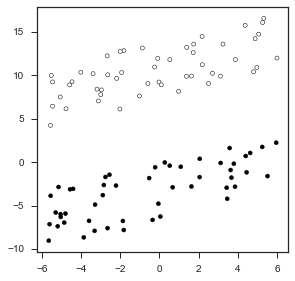

In [6]:
plt.figure(figsize=(4.5,4.5))
plt.scatter(X1[:,0], X1[:,1], s=16, c=Y1, cmap=plt.cm.gray, edgecolors='k', linewidth=0.5)
plt.show()

In [7]:
linmod0 = model.LinearModel(2)
linmod0.init(np.array([0.,0.5,-1.]))

In [8]:
loss_func0 = loss.MarginLoss(func.Hinge())
reg0 = regular.Square()
er0 = erisk(X, Y, linmod0, loss_func0, regular=reg0, tau=0.1)
fg0 = erm_fg(er0, h=0.1, tol=1.0e-6, n_iter=5000, verbose=1)

step: 1
K=5000 param=[-0.06693428 -0.25856502  0.0096189 ]


In [9]:
linmod1 = model.LinearModel(2)
linmod1.init(np.array([0.,0.5,-1.]))

In [10]:
loss_func1 = loss.MarginLoss(func.Hinge())
reg1 = regular.Square()
er1 = erisk(X1, Y1, linmod1, loss_func1, regular=reg1, tau=0.1)
fg1 = erm_fg(er1, h=0.1, tol=1.0e-6, n_iter=5000, verbose=1)

step: 1
K=5000 param=[-0.82605067 -0.12801648  0.26341475]


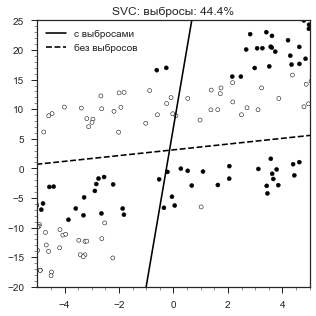

In [32]:
plt.figure(figsize=(4.5,4.5))
X1, X2 = X[:,0], X[:,1]
plt.title("SVC: выбросы: %.1f%%" % Q)
plt.scatter(X1, X2, c=Y, s=16, cmap=plt.cm.gray, edgecolors='k', linewidth=0.5)
draw_line(linmod0, X, Y, label='с выбросами') # label=r'$%.1f%.1fx+%.1fy$ (с выбросами)' % tuple(linmod0.param))
draw_line(linmod1, X, Y, linestyle='--', label='без выбросов') # , label=r'$%.1f%.1fx+%.1fy$ (без выбросов)' % tuple(linmod1.param)
plt.xlim(-5,5)
plt.ylim(-20,25)
plt.minorticks_on()
plt.legend()
plt.tight_layout()
plt.savefig('fig/linear_svm_1_%.0f.eps' % Q)
plt.show()

In [12]:
linmod2 = model.LinearModel(2)
linmod2.init(np.array([0.,-1.,1.]))

In [13]:
loss_func2 = loss.MarginLoss(func.Comp(func.Tukey(1.0), func.Hinge(1.0)))
# loss_func2 = loss.MarginLoss(func.Comp(func.Log(1), func.Hinge(1.0)))
reg2 = regular.Square()
er2 = erisk(X, Y, linmod2, loss_func2, regular=reg2, tau=0.05)
fg2 = erm_fg(er2, h=0.8, tol=1.0e-8, n_iter=5000, verbose=1)

step: 1
K=5000 param=[-0.01682878 -0.44329751  0.01558029]


In [14]:
linmod22 = model.LinearModel(2)
linmod22.init(np.array([0.,-1.,1.]))

In [15]:
loss_func22 = loss.MarginLoss(func.Comp(func.Log(1), func.Hinge(1.0)))
reg22 = regular.Square()
er22 = erisk(X, Y, linmod22, loss_func22, regular=reg22, tau=0.05)
fg22 = erm_fg(er22, h=0.8, tol=1.0e-8, n_iter=5000, verbose=1)

step: 1
K=5000 param=[-0.08114163 -0.40847923  0.02072515]


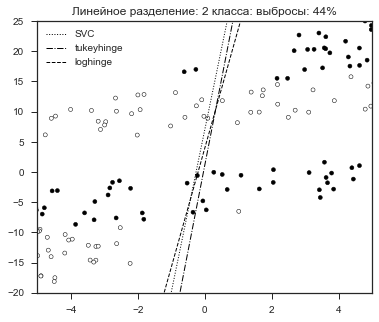

In [16]:
plt.figure(figsize=(6.,5.))
X1, X2 = X[:,0], X[:,1]
plt.title("Линейное разделение: 2 класса: выбросы: %.0f%%" % Q)
plt.scatter(X1, X2, c=Y, s=16, cmap=plt.cm.gray, edgecolors='k', linewidth=0.5)
draw_line(linmod0, X, Y, linestyle=':', label=r'SVC')
draw_line(linmod2, X, Y, linestyle='-.', label='tukeyhinge') 
draw_line(linmod22, X, Y, linestyle='--', label='loghinge')
plt.xlim(-5,5)
plt.ylim(-20,25)
plt.legend()
plt.savefig('fig/linear_svm_2_tlh_%.0f.eps' % Q)
plt.show()

In [17]:
linmod3 = model.LinearModel(np.array([0.,1.,1.]))
# linmod2.init(random=1)

step: 1
K=20 param=[-1.96371674 -0.29849871  0.54978413]


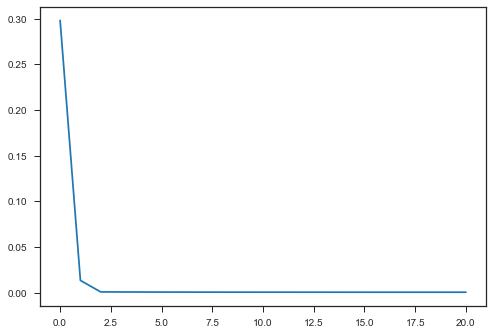

In [18]:
loss_func3 = loss.MarginLoss(func.Hinge(2.0))
alpha = 0.52 #M/(N+M)
reg3 = regular.Square()
er3 = erisk(X, Y, linmod3, loss_func3, regular=None, tau=0.1)
fg3 = fg(er3, h=0.01, tol=1.0e-6, n_iter=5000)
avg3 = averager_it(func.QuantileFunc(alpha, func.Sqrt(0.001)))
avg3 = avragg.WMAverage(avg3)
wg3 = weights.MWeights(avg3, er3)
alg3 = erm_irgd(fg3, wg3, n_iter=51, tol=1.0e-6, verbose=1)

plt.plot(alg3.lvals)
plt.show()

In [19]:
linmod4 = model.LinearModel(np.array([0.,1.,1.]))
# linmod2.init(random=1)

step: 1
K=6 param=[ 3.40776519 -4.31175041 -0.48703528]


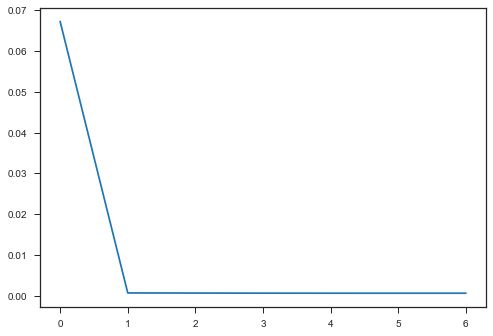

In [20]:
loss_func4 = loss.MarginLoss(func.Hinge(2.0))
alpha = 0.52 #M/(N+M)
reg4 = regular.Square()
er4 = erisk(X, Y, linmod4, loss_func4, regular=None, tau=0.1)
fg4 = fg(er4, h=0.05, tol=1.0e-6, n_iter=5000)
avg4 = averager_it(func.QuantileFunc(alpha, func.Sqrt(0.001)))
wg4 = weights.MWeights(avg4, er4, use_best_u=1)
alg4 = erm_irgd(fg4, wg4, n_iter=51, tol=1.0e-6, verbose=1)

plt.plot(alg4.lvals)
plt.show()

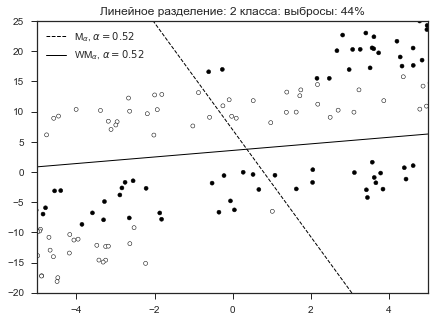

In [21]:
plt.figure(figsize=(7.,5.))
X1, X2 = X[:,0], X[:,1]
plt.title("Линейное разделение: 2 класса: выбросы: %.0f%%" % Q)
plt.scatter(X1, X2, c=Y, s=16, cmap=plt.cm.gray, edgecolors='k', linewidth=0.5)
# draw_line(linmod2, X, Y, linestyle='--', label='tukeyhinge') 
# draw_line(linmod22, X, Y, linestyle=':', label='loghinge')
draw_line(linmod4, X, Y, linestyle='--', label=r'M$_\alpha$, $\alpha=%.2f$' % alpha)
draw_line(linmod3, X, Y, label=r'WM$_\alpha$, $\alpha=%.2f$' % alpha) # , label=r'$%.1f%.1fx+%.1fy$ (без выбросов)' % tuple(linmod1.param)
plt.xlim(-5,5)
plt.ylim(-20,25)
plt.legend()
plt.savefig('fig/linear_svm_2_M_WM_%.0f.eps' % Q)
plt.show()